In [1]:
import torch
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GCNConv, GATConv

from dataHandler import ParticleDataset

import numpy as np
from time import time
import matplotlib.pyplot as plt
from matplotlib.patches import Circle,ConnectionPatch
plt.style.use('dark_background')

In [2]:
def distance_matrix(nodes):
    nodes=nodes
    _x = (nodes[:,0][...,None] - nodes[:,0])**2
    _y = (nodes[:,1][...,None] - nodes[:,1])**2
    matrix = torch.sqrt(_x + _y + 1e-8)
    return matrix

In [3]:
dataset = ParticleDataset('data/hz_test.hdf5','signal')
#data = dataset.__getitem__(0)
data_batches = DataLoader(dataset,batch_size=4,shuffle=False)

In [4]:
class GNN(torch.nn.Module):
    def __init__(self,_in,_h1,_out):
        super().__init__()
        self.conv1 = GCNConv(_in,_h1)
        self.conv2 = GCNConv(_h1,_out)
        
    def forward(self,data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = torch.tanh(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        #x = torch.tanh(x)
        return x

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(4,64,2).to(device)
model.double()
#optimizer = torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9,weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [206]:
model.train()
torch.autograd.set_detect_anomaly(True)
for epoch in range(50):
    ls = []
    t = time()
    for event in range(25):
        ls = []
        data = dataset.__getitem__(event)
        optimizer.zero_grad()
        out = model(data)
        #loss = my_loss(out,data.y)
        length = len(out)
        
        _input = distance_matrix(out)
        #_input = _input[torch.triu(torch.ones(length,length),diagonal=1) == 1]
        #_input.requires_grad_(False)
        
        _target = distance_matrix(data.y)
        #_target = _target[torch.triu(torch.ones(length,length),diagonal=1) == 1]
        #print(F.mse_loss(_input,_target))
        loss = F.mse_loss(_input,_target)
        #loss = F.mse_loss(out,data.y)
        #print('data',torch.mean(loss/_input), torch.mean(loss/_target))
        ls.append(loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        
    ls = torch.tensor(ls)
    print(f'epoch:{epoch}, event:{event}, mean loss:{torch.mean(ls.clone().detach())}, \
            time {round(time()-t,2)}')

epoch:0, event:24, mean loss:0.26780253029807727,             time 1.3
epoch:1, event:24, mean loss:0.29790686582022213,             time 1.44
epoch:2, event:24, mean loss:0.2652273219691753,             time 1.29
epoch:3, event:24, mean loss:0.2195512820552258,             time 1.24
epoch:4, event:24, mean loss:0.29659747433846606,             time 1.26
epoch:5, event:24, mean loss:0.28883476334006114,             time 1.44
epoch:6, event:24, mean loss:0.23509033594780507,             time 1.29
epoch:7, event:24, mean loss:0.2544619448693751,             time 1.3
epoch:8, event:24, mean loss:0.24422363186254842,             time 1.25
epoch:9, event:24, mean loss:0.21792893643544817,             time 1.29
epoch:10, event:24, mean loss:0.25234826477524486,             time 1.26
epoch:11, event:24, mean loss:0.2317062869877582,             time 1.22
epoch:12, event:24, mean loss:0.23131476600434284,             time 1.25
epoch:13, event:24, mean loss:0.23012043720491412,             time

In [6]:
model.train()
for epoch in range(1):
    loss = []
    t = time()
    for data in data_batches:
        optimizer.zero_grad()
        out = model(data)
        loss_temp = 0
        for graph_idx in torch.unique(data.batch):
            graph_mask = data.batch == graph_idx
            _x = out[graph_mask]
            _y = data.y[graph_mask]
            
            _input = distance_matrix(_x)
            _target = distance_matrix(_y)
        
            loss_temp += F.mse_loss(_input,_target)
            
        loss.append(loss_temp)
        
        loss_temp.backward()
        optimizer.step()
        
    loss = torch.tensor(loss)
    print(f'epoch:{epoch}, mean loss:{torch.mean(loss.clone().detach())}, \
          time {round(time()-t,2)}')

epoch:0, mean loss:1.341827692014309,           time 23.67


In [11]:
torch.save(model,'model_scripted.pt')

# Example 

loss is: 0.3186292073571476


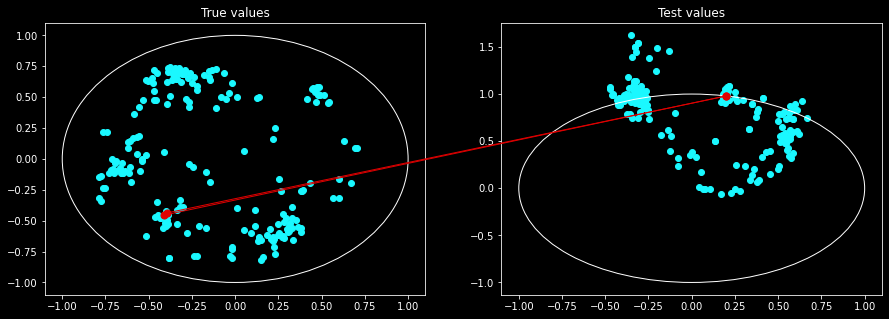

In [13]:
model = torch.load('model_scripted.pt')
model.eval()
data = dataset.__getitem__(0)
out = model(data)

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax = ax.flatten()
ax[0].scatter(data.y[:,0],data.y[:,1],alpha=1,color='#1AF8FF')
ax[0].set_title('True values')

test = out.detach().clone()
ax[1].scatter(test[:,0],test[:,1],alpha=1,color='#1AF8FF')
ax[1].set_title('Test values')

disk = Circle((0,0),1,color='white',fill=False)
disk2 = Circle((0,0),1,color='white',fill=False)

ax[0].add_patch(disk)
ax[1].add_patch(disk2)

idxs = [0,1]
for idx00 in idxs:
    xy_left = data.y[idx00]
    xy_right = test[idx00]

    ax[0].scatter(xy_left[0],xy_left[1],alpha=1,color='#DF0101',s = 50)
    ax[1].scatter(xy_right[0],xy_right[1],s=50,c='#DF0101') #change color
    con = ConnectionPatch(xyA=xy_left, coordsA=ax[0].transData,xyB=xy_right, coordsB=ax[1].transData,color='#DF0101')
    fig.add_artist(con)

length = len(out)
_input = distance_matrix(out)
_input = _input[torch.triu(torch.ones(length,length),diagonal=1) == 1]
_target = distance_matrix(data.y)
_target = _target[torch.triu(torch.ones(length,length),diagonal=1) == 1]
loss = F.mse_loss(_input,_target)
print(f'loss is: {loss}')    
plt.show()

In [117]:
from manifold import PoincareManifold
poincare = PoincareManifold()

In [172]:
poincare.distance(data.y,data.y)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)